# Бурение скважины

Необходимо решить, где бурить новую скважину, с помощью модели машинного обучения, которая позволит определить регион, который принесет наибольшую прибыль, на основании данных о пробах нефти в трех регионах, где в каждом располагается 10000 месторождений.

- При разведке региона проводится исследование 500 точек.
- Бюджет на разработку месторождений — 10 млрд рублей, стоимость бурения одной скважины — 50 млн рублей.
- Один баррель сырья приносит 4500 рублей прибыли.
- Не рассматривать регионы, в которых риск убытков выше 2.5%. Из оставшихся выбирается регион с наибольшей средней прибылью.

### Описание данных

- id — уникальный идентификатор месторождения;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в месторождении (тыс. баррелей).

### Библиотеки и модули

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### Содержание

1. Предобработка данных
    - Первичная предобработка
    - Распределения признаков
2. Обучение и проверка модели
    - Предобработка для машинного обучения
    - Обучение моделей машинного обучения
    - Проверка моделей машинного обучения
3. Подготовка к расчету прибыли
4. Расчет прибыли и рисков
5. Вывод

## Предобработка данных

In [2]:
geo_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
geo_0.head(5)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
geo_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [5]:
geo_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Столбце id не несет в себе никакой информации для обучения моделей, поэтому дропним его из наших выборок.

In [6]:
geo_0 = geo_0.drop(['id'], axis=1)
geo_1 = geo_1.drop(['id'], axis=1)
geo_2 = geo_2.drop(['id'], axis=1)

In [7]:
geo_0.head(1)

,f0,f1,f2,product
0,0.705745,-0.497823,1.22117,105.280062


### Первичная предобработка

Посмотрим на общую информацию каждой из выборок регионов перед предобработкой.

#### geo_0

In [8]:
print(geo_0.info())
print(geo_0.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4)
memory usage: 3.1 MB
None
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089
max         2.362331       1.343769      16.003790     185.364347


In [9]:
geo_0.duplicated().sum()

0

Каких-либо не корректностей с типами данных и пропусками нет. Дубликатов тоже нет.

#### geo_1

In [10]:
print(geo_1.info())
print(geo_1.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4)
memory usage: 3.1 MB
None
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.796579       2.494541      68.825000
std         8.965932       5.119872       1.703572      45.944423
min       -31.609576     -26.358598      -0.018144       0.000000
25%        -6.298551      -8.267985       1.000021      26.953261
50%         1.153055      -4.813172       2.011479      57.085625
75%         8.621015      -1.332816       3.999904     107.813044
max        29.421755      18.734063       5.019721     137.945408


In [11]:
geo_1.duplicated().sum()

0

Каких-либо не корректностей с типами данных и пропусками нет. Дубликатов тоже нет.

#### geo_2

In [12]:
print(geo_2.info())
print(geo_2.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4)
memory usage: 3.1 MB
None
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.002023      -0.002081       2.495128      95.000000
std         1.732045       1.730417       3.473445      44.749921
min        -8.760004      -7.084020     -11.970335       0.000000
25%        -1.162288      -1.174820       0.130359      59.450441
50%         0.009424      -0.009482       2.484236      94.925613
75%         1.158535       1.163678       4.858794     130.595027
max         7.238262       7.844801      16.739402     190.029838


In [13]:
geo_2.duplicated().sum()

0

Каких-либо не корректностей с типами данных и пропусками нет. Дубликатов тоже нет.

### Распределения признаков

#### Регион 0

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


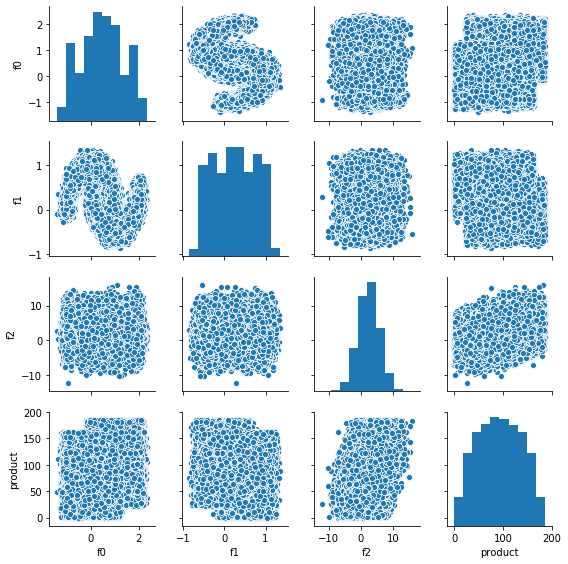

In [14]:
sns.pairplot(geo_0, size=2)
plt.show()

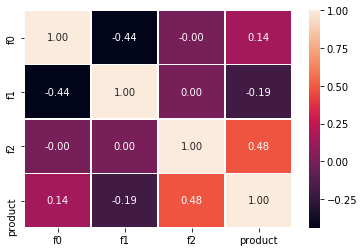

In [15]:
sns.heatmap(geo_0.corr(), linewidth=.5, annot=True, fmt='.2f')
plt.show()

Заметим, что в регионе 0 целевая переменная коррелирует значительнее с f2. Также можем наблюдать корреляцию в -0.44 между f1 и f0.

#### Регион 1

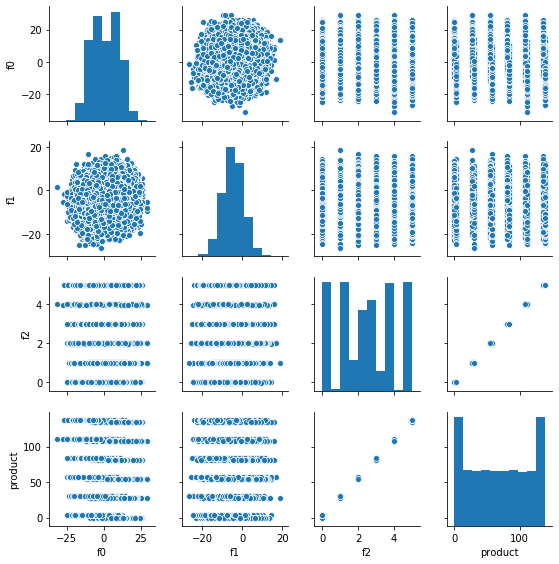

In [16]:
sns.pairplot(geo_1, size=2)
plt.show()

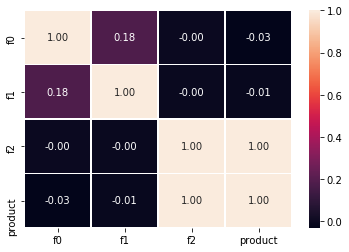

In [17]:
sns.heatmap(geo_1.corr(), linewidth=.5, annot=True, fmt='.2f')
plt.show()

Product в регионе 1 вообще никак не коррелирует с f0 и f1. Видим, что значений корреляции признака f2 и целевой переменной равно 1. Утечка целевой переменной?

#### Регион 2

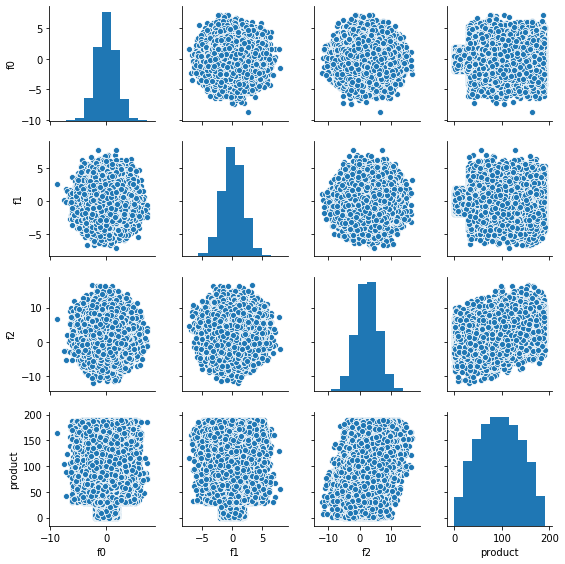

In [18]:
sns.pairplot(geo_2, size=2)
plt.show()

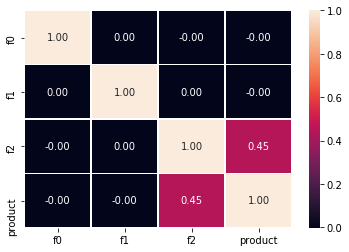

In [19]:
sns.heatmap(geo_2.corr(), linewidth=.5, annot=True, fmt='.2f')
plt.show()

В регионе 3 нет вообще даже никакого намека на корреляцию между целевой переменной и f0 и f1. Видим, что присутствует корреляция в 0.45 между product и f2.

## Обучение и проверка модели

### Предобработка для машинного обучения

Разделим признаки и целевую переменную отдельно.

In [20]:
X_geo_0 = geo_0.drop(['product'], axis=1)
y_geo_0 = geo_0['product']
X_geo_1 = geo_1.drop(['product'], axis=1)
y_geo_1 = geo_1['product']
X_geo_2 = geo_2.drop(['product'], axis=1)
y_geo_2 = geo_2['product']

In [21]:
X_geo_0.head(5)

,f0,f1,f2
0,0.705745,-0.497823,1.221170
1,1.334711,-0.340164,4.365080
2,1.022732,0.151990,1.419926
3,-0.032172,0.139033,2.978566
4,1.988431,0.155413,4.751769


In [22]:
y_geo_0.head(5)

0    105.280062
1     73.037750
2     85.265647
3    168.620776
4    154.036647
Name: product, dtype: float64

In [23]:
header = X_geo_0.columns

Разобьем данные на обучающую и тестовую выборки.

In [24]:
X_geo_0_train, X_geo_0_test, y_geo_0_train, y_geo_0_test = train_test_split(X_geo_0, y_geo_0, test_size=0.25, random_state=7)
X_geo_1_train, X_geo_1_test, y_geo_1_train, y_geo_1_test = train_test_split(X_geo_1, y_geo_1, test_size=0.25, random_state=7)
X_geo_2_train, X_geo_2_test, y_geo_2_train, y_geo_2_test = train_test_split(X_geo_2, y_geo_2, test_size=0.25, random_state=7)

Промасштабируем выборки X.

In [25]:
def scaler(scaler_type, data_train, data_test, header):
    scaler = scaler_type
    scaler.fit(data_train)
    data_train = pd.DataFrame(scaler.transform(data_train), columns=header)
    data_test = pd.DataFrame(scaler.transform(data_test), columns=header)
    return data_train, data_test

In [26]:
X_geo_0_train, X_geo_0_test = scaler(StandardScaler(), X_geo_0_train, X_geo_0_test, header)

In [27]:
X_geo_1_train, X_geo_1_test = scaler(StandardScaler(), X_geo_1_train, X_geo_1_test, header)
X_geo_2_train, X_geo_2_test = scaler(StandardScaler(), X_geo_2_train, X_geo_2_test, header)

In [28]:
X_geo_2_test

,f0,f1,f2
0,0.480635,1.706556,-0.030089
1,-0.394470,-0.379462,0.199584
2,0.647668,-2.249029,0.669853
3,-2.208684,-0.172720,1.272465
4,0.464992,-1.183390,-1.326995
...,...,...,...
24995,-0.850757,-0.320500,1.687645
24996,-0.495847,-1.205380,1.423052
24997,0.221465,-0.675746,-0.297250
24998,-0.735205,1.221609,-2.260578


### Обучение моделей машинного обучения

#### Регион 0

In [29]:
model_0 = LinearRegression()
model_0.fit(X_geo_0_train, y_geo_0_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

#### Регион 1

In [30]:
model_1 = LinearRegression()
model_1.fit(X_geo_1_train, y_geo_1_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

#### Регион 2

In [31]:
model_2 = LinearRegression()
model_2.fit(X_geo_2_train, y_geo_2_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Проверка моделей машинного обучения

Посчитаем среднее по таргету обучающих выборок по каждому региону.

In [32]:
print(f'Средний объем запасов в регионе 0: {y_geo_0_train.mean()}')
print(f'Средний объем запасов в регионе 1: {y_geo_1_train.mean()}')
print(f'Средний объем запасов в регионе 2: {y_geo_2_train.mean()}')

Средний объем запасов в регионе 0: 92.45697862027514
Средний объем запасов в регионе 1: 68.83062102195872
Средний объем запасов в регионе 2: 95.03679073250363


Средний запас в 0 и 2 регионах почти одинаков. В 1 регионе значительнее ниже.

In [33]:
y_geo_0_pred = pd.Series(model_0.predict(X_geo_0_test))
y_geo_1_pred = pd.Series(model_1.predict(X_geo_1_test))
y_geo_2_pred = pd.Series(model_2.predict(X_geo_2_test))

In [34]:
print(f'Качество модели (RMSE) для нулевого региона: {np.sqrt(mean_squared_error(y_geo_0_pred, y_geo_0_test))}')
print(f'Качество модели (RMSE) для первого региона: {np.sqrt(mean_squared_error(y_geo_1_pred, y_geo_1_test))}')
print(f'Качество модели (RMSE) для второго региона: {np.sqrt(mean_squared_error(y_geo_2_pred, y_geo_2_test))}')

Качество модели (RMSE) для нулевого региона: 37.61698862149409
Качество модели (RMSE) для первого региона: 0.8901574284390835
Качество модели (RMSE) для второго региона: 39.92612735265435


Высокое значение RMSE на моделях нулевого и второго регионов. Вероятнее всего такая ошибка связана с тем, что распределение признаков с целевой переменной шумное.

## Подготовка к расчёту прибыли

In [35]:
# рассчет в млн. 
P_OIL = 0.0045
DEV_FEILDS = 10000
TC_WELL = 50

In [36]:
print(TC_WELL / P_OIL)

11111.111111111111


Средний минимальный объем сырья в месторождениях должен быть равен 50/0.0045 ~ 11111.11 (тыс. баррелей). Получив такой объем скважина может быть окуплена в ноль (рассчет без учета бюджета на разработку месторождений).

In [37]:
def profit_for_wells(products):
    total_product = products.sum()
    tr = P_OIL * total_product * 1000 # домнажаю на 1000, т.к. объемы баррелей в тыс.
    tc = TC_WELL * len(products)
    return tr - tc

## Расчёт прибыли и рисков 

In [38]:
state = np.random.RandomState(7)

In [39]:
# использую технику бутстрапа для получения распределения прибыли для региона на 1000 разных подвыборках
def dist_profit_for_reg_using_bootstrap(y_geo_reg_test, y_geo_reg_pred):
    y_geo_reg_test.reset_index(drop=True, inplace=True)
    y_geo_reg_pred.reset_index(drop=True, inplace=True)
    profits_reg = []
    for i in range(1000):
        y_geo_reg_intel = y_geo_reg_pred.sample(n=500, replace=True, random_state=state)
        y_geo_reg_best_pred = y_geo_reg_intel.sort_values(ascending=False).head(200) # т.к. у нас бюджет ограничен 10 млрд.
        y_geo_reg_real = y_geo_reg_test[y_geo_reg_best_pred.index]
        profits_reg.append(profit_for_wells(y_geo_reg_real))
    return pd.Series(profits_reg)

#### Регион 0

In [40]:
profits_0 = dist_profit_for_reg_using_bootstrap(y_geo_0_test, y_geo_0_pred)

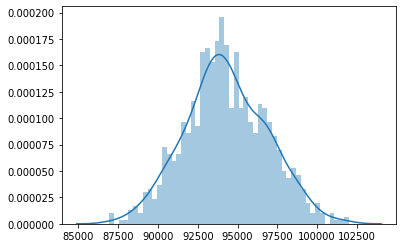

In [41]:
sns.distplot(np.array(profits_0), bins=50)
plt.show()

In [42]:
print(f'Средняя прибыль в регионе 0: {round(profits_0.mean(), 2)} (млн.)')

Средняя прибыль в регионе 0: 94272.58 (млн.)


Построим 95%-й доверительный интервал.

In [43]:
confidence_interval_0 = st.t.interval(0.95, len(profits_0) - 1, profits_0.mean(), profits_0.sem())

In [44]:
print(f'Доверительный интервал: {confidence_interval_0}')

Доверительный интервал: (94112.8042248966, 94432.3505051622)


Посчитаем риск убытков. Он не должен быть выше 2.5%.

In [45]:
print(f'Доля убыточных скважин: {len(profits_0[profits_0 < 0]) / len(profits_0) * 100}%')

Доля убыточных скважин: 0.0%


#### Регион 1

In [46]:
profits_1 = dist_profit_for_reg_using_bootstrap(y_geo_1_test, y_geo_1_pred)

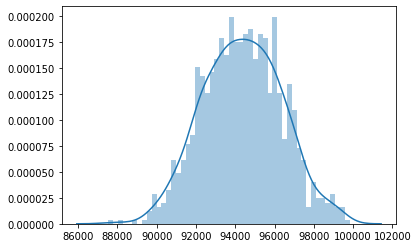

In [47]:
sns.distplot(np.array(profits_1), bins=50)
plt.show()

In [48]:
print(f'Средняя прибыль в регионе 0: {round(profits_1.mean(), 2)} (млн.)')

Средняя прибыль в регионе 0: 94364.33 (млн.)


Построим 95%-й доверительный интервал.

In [49]:
confidence_interval_1 = st.t.interval(0.95, len(profits_1) - 1, profits_1.mean(), profits_1.sem())

In [50]:
print(f'Доверительный интервал: {confidence_interval_1}')

Доверительный интервал: (94239.55712043913, 94489.09543149875)


Посчитаем риск убытков. Он не должен быть выше 2.5%.

In [51]:
print(f'Доля убыточных скважин: {len(profits_0[profits_0 < 0]) / len(profits_0) * 100}%')

Доля убыточных скважин: 0.0%


#### Регион 2

In [52]:
profits_2 = dist_profit_for_reg_using_bootstrap(y_geo_2_test, y_geo_2_pred)

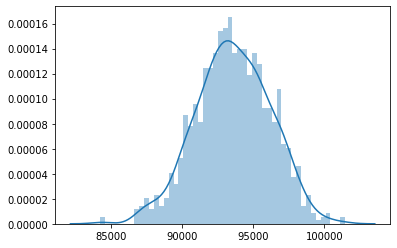

In [53]:
sns.distplot(np.array(profits_2), bins=50)
plt.show()

In [54]:
print(f'Средняя прибыль в регионе 0: {round(profits_2.mean(), 2)} (млн.)')

Средняя прибыль в регионе 0: 93587.02 (млн.)


Построим 95%-й доверительный интервал.

In [55]:
confidence_interval_2 = st.t.interval(0.95, len(profits_2) - 1, profits_2.mean(), profits_2.sem())

In [56]:
print(f'Доверительный интервал: {confidence_interval_2}')

Доверительный интервал: (93425.10114784428, 93748.94711849414)


Посчитаем риск убытков. Он не должен быть выше 2.5%.

In [57]:
print(f'Доля убыточных скважин: {len(profits_0[profits_0 < 0]) / len(profits_0) * 100}%')

Доля убыточных скважин: 0.0%


## Вывод

Проведя анализ месторождений в трех регионах, получили, что во всех трех регионах средняя прибыль положительна и составляет более 90 млрд. Рисков от бурения скважин в трех регионах также нет. Поскольку нужно выбрать только один регион для разработки месторождений, то выберем регион 1, поскольку в нем средняя прибыль наибольшая по сравнению с другими регионами. В регионе 1 - около 94364.33.